In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from datetime import timedelta

In [31]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D

In [32]:
df_ct = pd.read_csv('./data/시티랩스_모델데이터1.csv',index_col=0)
df_ct.head()

,일자,종가,등락률,거래대금,매출액(억원),영업이익(억원),당기순이익(억원),지배주주순이익(억원),자산총계(억원),부채총계(억원),...,EPS(원),BPS(원),PBR(배),고가-종가,고가-시가,고가-저가,종가-시가,종가-저가,시가-저가,전환사채전환총액
1,2016-01-05,3020,0.00,-0.452066,-0.229885,0.666667,4.5,4.5,-0.022624,-0.283582,...,3.357143,0.00627,1.88,-0.913043,-0.176471,-0.200000,-3.000000,8.000000,-0.250000,-0.8
2,2016-01-06,2895,-4.14,0.292444,-0.229885,0.666667,4.5,4.5,-0.022624,-0.283582,...,3.357143,0.00627,1.88,16.000000,-0.071429,1.250000,-2.750000,-0.388889,4.333333,-0.8
3,2016-01-07,2945,1.73,0.843234,-0.229885,0.666667,4.5,4.5,-0.022624,-0.283582,...,3.357143,0.00627,1.88,-0.088235,2.615385,0.155556,-1.761905,0.909091,-0.843750,-0.8
4,2016-01-08,2920,-0.85,-0.546023,-0.229885,0.666667,4.5,4.5,-0.022624,-0.283582,...,3.357143,0.00627,1.88,-0.870968,-0.829787,-0.288462,-0.750000,0.571429,4.800000,-0.8
5,2016-01-11,2810,-3.77,-0.349444,-0.229885,0.666667,4.5,4.5,-0.022624,-0.283582,...,3.357143,0.00627,1.88,5.250000,-0.375000,-0.270270,-6.000000,-0.939394,-0.241379,-0.8


In [33]:
 df_ct.columns

Index(['일자', '종가', '등락률', '거래대금', '매출액(억원)', '영업이익(억원)', '당기순이익(억원)',
       '지배주주순이익(억원)', '자산총계(억원)', '부채총계(억원)', '자본총계(억원)', '자본금(억원)', '부채비율(%)',
       '영업이익률(%)', '지배주주순이익률(%)', 'ROA(%)', 'ROE(%)', 'EPS(원)', 'BPS(원)',
       'PBR(배)', '고가-종가', '고가-시가', '고가-저가', '종가-시가', '종가-저가', '시가-저가',
       '전환사채전환총액'],
      dtype='object')

In [34]:
df_ct1 = df_ct[['등락률', '거래대금','고가-종가', '고가-시가', '고가-저가', '종가-시가', '종가-저가', '시가-저가']]

In [35]:
df_ct1.head(3)

,등락률,거래대금,고가-종가,고가-시가,고가-저가,종가-시가,종가-저가,시가-저가
1,0.00,-0.452066,-0.913043,-0.176471,-0.200000,-3.000000,8.000000,-0.250000
2,-4.14,0.292444,16.000000,-0.071429,1.250000,-2.750000,-0.388889,4.333333
3,1.73,0.843234,-0.088235,2.615385,0.155556,-1.761905,0.909091,-0.843750


In [36]:
for i in range(len(df_ct1.columns)):
    
    if np.inf in df_ct1.iloc[:,i].unique():
        print(i)  
        
    else:
        print('없음')

없음
1
없음
없음
없음
없음
없음
없음


In [37]:
df_ct1[df_ct1.거래대금 == np.inf]

,등락률,거래대금,고가-종가,고가-시가,고가-저가,종가-시가,종가-저가,시가-저가
275,-11.63,inf,-1.090116,39.0,324.0,-1.078488,-0.995640,284.0
281,-7.62,inf,-1.068254,99.0,214.0,-1.036508,-0.999683,114.0
501,-2.35,inf,-1.239216,359.0,1339.0,-1.168627,-0.976471,979.0
1100,-8.92,inf,-1.069231,22.0,45.0,-1.033846,-0.998462,22.0


In [38]:
df_ct2 = df_ct1[df_ct1.거래대금 != np.inf]
df_ct2.head()

,등락률,거래대금,고가-종가,고가-시가,고가-저가,종가-시가,종가-저가,시가-저가
1,0.00,-0.452066,-0.913043,-0.176471,-0.200000,-3.000000,8.000000,-0.250000
2,-4.14,0.292444,16.000000,-0.071429,1.250000,-2.750000,-0.388889,4.333333
3,1.73,0.843234,-0.088235,2.615385,0.155556,-1.761905,0.909091,-0.843750
4,-0.85,-0.546023,-0.870968,-0.829787,-0.288462,-0.750000,0.571429,4.800000
5,-3.77,-0.349444,5.250000,-0.375000,-0.270270,-6.000000,-0.939394,-0.241379


In [39]:
df_ct2.shape

(1470, 8)

In [51]:
window_size = 10
target_period = 10

X = []
Y = []


for i in range(len(df_ct2) - window_size-target_period): 
    
    # 피쳐값 
    X.append([df_ct2.iloc[i+j,1:] for j in range(window_size)]) # j= 0부터 29 -> 30일치 데이터

    # 등락률 
    Y.append([df_ct2.iloc[window_size+i+j,0] for j in range(target_period)])
    
Y1 = []
for y in Y:
    toggle = 0
    for i in y:

        if i >= 7:
            Y1.append(1)
            toggle = 1
            break
    if toggle != 1:
        Y1.append(0)


In [52]:
X_ary = np.array(X).astype(float)
Y1_ary = np.array(Y1).astype(float)

In [53]:
train_test_split = 1100

x_train = X_ary[:1100]
y_train = Y1_ary[:1100]

x_test = X_ary[1100:]
y_test = Y1_ary[1100:]

In [54]:
x_train.shape

(1100, 10, 7)

In [55]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(100, input_shape=(10,7)))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               43200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


In [56]:
# learning rate 설정
Adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [57]:
model.compile(loss='binary_crossentropy', metrics ='accuracy', optimizer=Adam)

In [58]:
hist = model.fit(x_train, y_train, epochs=50, batch_size= 10, validation_data= (x_test,y_test))

Epoch 1/50
110/110 [==============================] - 2s 7ms/step - loss: 0.6340 - accuracy: 0.6755 - val_loss: 0.6351 - val_accuracy: 0.7143
Epoch 2/50
110/110 [==============================] - 1s 5ms/step - loss: 0.6016 - accuracy: 0.6891 - val_loss: 0.6232 - val_accuracy: 0.7229
Epoch 3/50
110/110 [==============================] - 1s 5ms/step - loss: 0.5877 - accuracy: 0.6955 - val_loss: 0.6205 - val_accuracy: 0.7229
Epoch 4/50
110/110 [==============================] - 1s 5ms/step - loss: 0.5746 - accuracy: 0.7009 - val_loss: 0.6205 - val_accuracy: 0.7314
Epoch 5/50
110/110 [==============================] - 1s 5ms/step - loss: 0.5612 - accuracy: 0.7027 - val_loss: 0.6247 - val_accuracy: 0.7343
Epoch 6/50
110/110 [==============================] - 1s 5ms/step - loss: 0.5466 - accuracy: 0.7245 - val_loss: 0.6298 - val_accuracy: 0.7343
Epoch 7/50
110/110 [==============================] - 1s 5ms/step - loss: 0.5284 - accuracy: 0.7282 - val_loss: 0.6401 - val_accuracy: 0.7371
Epoch 

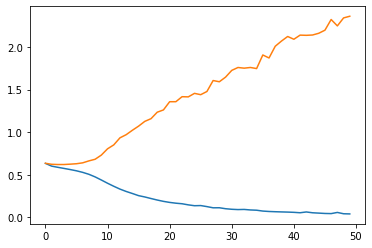

In [61]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

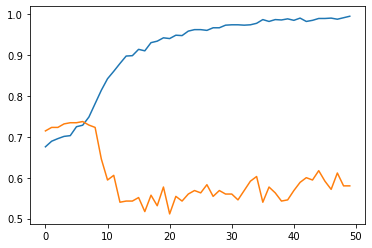

In [62]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

In [63]:
model.evaluate(x_test,y_test)

11/11 [==============================] - 0s 3ms/step - loss: 2.3606 - accuracy: 0.5800


[2.3606090545654297, 0.5799999833106995]

In [22]:
pred = model.predict(x_test)
len(pred)

340

In [23]:
pred

array([[3.84225947e-04],
       [1.09614521e-04],
       [1.16252428e-04],
       [3.47803556e-03],
       [8.07909202e-03],
       [7.63557712e-03],
       [1.88666843e-02],
       [1.87168666e-03],
       [4.34510177e-04],
       [1.19438220e-04],
       [4.13860434e-05],
       [2.81013490e-05],
       [3.02313492e-05],
       [8.72145174e-05],
       [4.95317800e-05],
       [5.05676471e-05],
       [4.50252264e-05],
       [5.71652963e-05],
       [1.80976829e-04],
       [4.59768297e-03],
       [1.13763206e-03],
       [1.10148778e-03],
       [8.95405747e-03],
       [6.98244050e-02],
       [2.73335934e-01],
       [9.98107314e-01],
       [9.99278009e-01],
       [9.99485731e-01],
       [9.99578297e-01],
       [9.99462664e-01],
       [9.99584973e-01],
       [9.99713004e-01],
       [9.99753654e-01],
       [9.97108519e-01],
       [1.65593368e-03],
       [1.83848839e-03],
       [1.51322616e-04],
       [8.09156190e-05],
       [4.60072006e-05],
       [2.09340680e-04],


In [24]:
ans = []
for i in pred:
    ans.append(round(i[0]))

In [26]:
from collections import Counter
Counter(ans)

Counter({0: 281, 1: 59})

In [27]:
Counter(y_test)

Counter({0.0: 242, 1.0: 98})

In [28]:
len(y_test)

340